In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Load data

In [2]:
def get_data():
    
    try:
        columns = np.load("data_columns.npy")
        X = np.load("data_valence_physio_for_svm.npy")
        Y = np.load("data_valence_label_for_svm.npy")
        return pd.DataFrame(X, columns=columns), pd.DataFrame(Y)
    except:
        print "No stored files found.. load from files first"

In [3]:
X, Y = get_data()
print X.shape
print Y.shape

(321600, 24)
(321600, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3caa7d210>]],
      dtype=object)

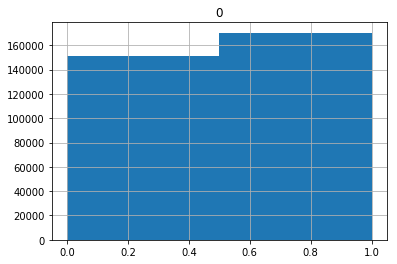

In [4]:
# binarize the problem
Y[Y<=4] = 0
Y[Y>=5] = 1
Y.hist(bins=2)

## LinearSVC train and test

In [ ]:
# reshape data for estimator
lsvc = SVC(C=2, tol=1e-5, class_weight='balanced', verbose=True)

# evaluate using 5-fold cross validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(lsvc, X, Y, cv=stratified_cv, verbose=0)

print
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

## KBest Feature selection + SVC

In [6]:
# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
import sklearn.feature_selection

In [7]:
scores_by_kbest = []

for k in range(1,24):

    kbest_selector = sklearn.feature_selection.SelectKBest(k=k)
    kbest_selector.fit(X, Y)
    
    results = cross_val_score(lsvc, kbest_selector.transform(X), Y, cv=stratified_cv, verbose=0)

    ks = {
        "feature" : X.columns[kbest_selector.get_support()],
        "score" : results.mean(),
        "std"   : results.std()
    }
    
    scores_by_kbest.append(ks)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

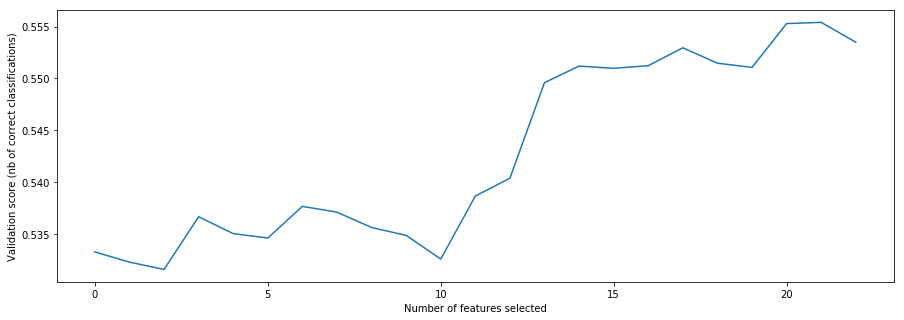

In [8]:
scores = [ s["score"] for s in scores_by_kbest ]
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Validation score (nb of correct classifications)")
plt.plot(np.arange(len(scores)), scores)
plt.show()

In [9]:
max_score = max(scores_by_kbest, key=lambda x: x["score"])

print
print("Accuracy: %.2f%% (%.2f%%)" % (max_score["score"]*100, max_score["std"]*100))


Accuracy: 55.54% (0.12%)


## Univariate Feature Selection + SVC

In [10]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [11]:
percentile_selector = SelectPercentile(f_classif, percentile=10)
percentile_selector.fit(X, Y)

SelectPercentile(percentile=10,
         score_func=<function f_classif at 0x7fb3cea387d0>)

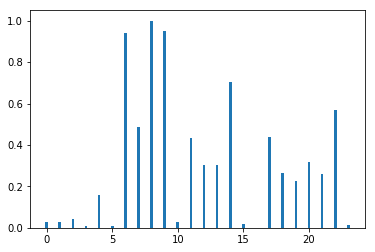

Index([u'EDA_mean', u'EDA_min', u'EDA_max'], dtype='object')

In [12]:
scores = -np.log10(percentile_selector.pvalues_)
scores[np.isinf(scores)] = scores[np.isfinite(scores)].max()
scores /= scores.max()
plt.bar(np.arange(X.shape[1]), scores, width=.2)
plt.show()

X.columns[percentile_selector.get_support()]

In [13]:
results = cross_val_score(lsvc, percentile_selector.transform(X), Y, cv=stratified_cv, verbose=0)

print
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
Accuracy: 53.16% (0.07%)


## Recursive feature selection

In [14]:
rfecv = RFECV(estimator=lsvc, step=1, cv=stratified_cv, scoring='accuracy', n_jobs=-1)

In [15]:
rfecv.fit(X, Y)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

RFECV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
   estimator=LinearSVC(C=2, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1e-05,
     verbose=True),
   min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
   verbose=0)

In [16]:
rfecv.estimator_.coef_

array([[ 5.39226925, -2.99521659, -2.61896311,  3.0959875 , -0.84109786,
        -3.26824295,  0.76067596]])

In [17]:
print("Optimal number of features : %d" % rfecv.n_features_)
print X.columns[rfecv.get_support()]

print
print("Accuracy: %.2f%% (%.2f%%)" % (rfecv.grid_scores_[rfecv.n_features_ - 1]*100, 0))

Optimal number of features : 7
Index([u'EDA_mean', u'EDA_min', u'EDA_max', u'SKT_mean', u'SKT_std',
       u'SKT_min', u'SKT_mean_abs_diff'],
      dtype='object')

Accuracy: 55.91% (0.00%)


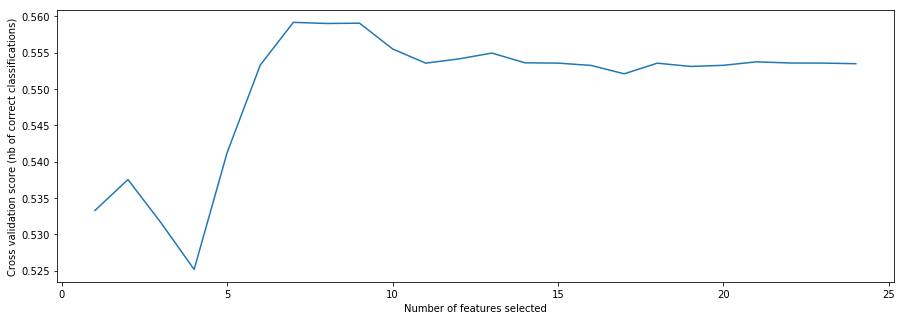

In [18]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()